In [17]:
# Import libraries
import torch
from PIL import Image
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Loading Data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:09<00:00, 999350.96it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 265910.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1444144.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2706810.00it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Define the image classifier model
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 22 * 22, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [5]:
# Create an instance of the image classifier model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = ImageClassifier().to(device)

In [6]:
# Define the optimizer and loss function
optimizer = Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [7]:
# Train the model
for epoch in range(10):  # Train for 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        outputs = classifier(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f"Epoch:{epoch} loss is {loss.item()}")

Epoch:0 loss is 0.023113185539841652
Epoch:1 loss is 0.0043427408672869205
Epoch:2 loss is 0.009371272288262844
Epoch:3 loss is 0.008824288845062256
Epoch:4 loss is 0.058558057993650436
Epoch:5 loss is 0.10023767501115799
Epoch:6 loss is 0.00219330913387239
Epoch:7 loss is 8.129623893182725e-05
Epoch:8 loss is 0.00641291169449687
Epoch:9 loss is 7.078048724906694e-08


In [8]:
# Save the trained model
torch.save(classifier.state_dict(), 'model_state.pt')

In [9]:


# Load the saved model
with open('model_state.pt', 'rb') as f: 
     classifier.load_state_dict(load(f))  

Predicted label: 3
Confidence: 0.9999998807907104


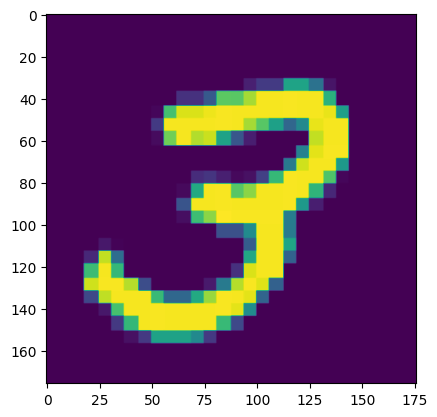

In [18]:
# Perform inference on an image
img = Image.open('one.png').convert('L')
plt.imshow(img)
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
output = classifier(img_tensor)
probs = torch.softmax(output, dim=1)
predicted_label = torch.argmax(probs, dim=1).item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence: {torch.max(probs).item()}")

Predicted label: 2
Confidence: 0.9654443860054016


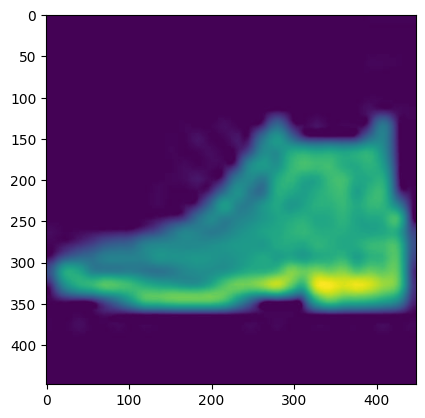

In [19]:
# Perform inference on an image
img = Image.open('shoe.png').convert('L')
plt.imshow(img)
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
output = classifier(img_tensor)
probs = torch.softmax(output, dim=1)
predicted_label = torch.argmax(probs, dim=1).item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence: {torch.max(probs).item()}")

In [ ]:

# Temperature Scaling
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return logits / self.temperature

def temperature_scale(model, valid_loader):
    model.eval()
    logits_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    temp_model = ModelWithTemperature(model).to(device)
    optimizer = Adam([temp_model.temperature], lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(100):
        optimizer.zero_grad()
        loss = loss_fn(temp_model(logits), labels)
        loss.backward()
        optimizer.step()

    return temp_model


In [ ]:

# MC Dropout
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def mc_dropout_predict(model, data_loader, n_iter=20):
    model.eval()
    enable_dropout(model)
    all_preds = []
    with torch.no_grad():
        for _ in range(n_iter):
            preds = []
            for x, _ in data_loader:
                x = x.to(device)
                output = torch.softmax(model(x), dim=1)
                preds.append(output.cpu())
            all_preds.append(torch.cat(preds))
    return torch.stack(all_preds)


In [ ]:

# Deep Ensemble
def train_ensemble(n_models, train_loader, epochs=3):
    ensemble = []
    for i in range(n_models):
        model = ImageClassifier().to(device)
        optimizer = Adam(model.parameters(), lr=0.001)
        for epoch in range(epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(model(x), y)
                loss.backward()
                optimizer.step()
        ensemble.append(model)
    return ensemble

def ensemble_predict(ensemble, data_loader):
    all_preds = []
    for model in ensemble:
        model.eval()
        preds = []
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                output = torch.softmax(model(x), dim=1)
                preds.append(output.cpu())
        all_preds.append(torch.cat(preds))
    return torch.stack(all_preds)


In [ ]:

# Test-Time Augmentation (TTA)
def tta_predict(model, data_loader, transform_fn, n_augmentations=10):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            aug_preds = []
            for _ in range(n_augmentations):
                x_aug = transform_fn(x)
                preds = torch.softmax(model(x_aug), dim=1)
                aug_preds.append(preds.cpu())
            all_preds.append(torch.stack(aug_preds).mean(dim=0))
    return torch.cat(all_preds)
